# ResBlock MLP Network with Hadamard Layer


## 1. Pretreatment


Read data from `.mat` files.

In [1]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import yaml

import torch
import torch.nn as nn
from torchinfo import summary

with open("./config/HL_ResBlock.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

Import data.

In [2]:
InputData = sp.io.loadmat(config["DATA_LOADER"]["INPUT_DATA_PATH"])
InputData = torch.from_numpy(InputData["KinematicsData"])
OutputData = sp.io.loadmat(config["DATA_LOADER"]["OUTPUT_DATA_PATH"])
OutputData = torch.from_numpy(OutputData["DynRegData"])

Import `NN_utils` and `Visualization`.

In [3]:
import sys

sys.path.append("../utils")
from NN_utils import *
from Visualization import *

SETUP_SEED(42)
torch.set_default_dtype(torch.float64)

Size of input and output data.

In [4]:
InputData.shape, OutputData.shape

(torch.Size([50000, 8]), torch.Size([50000, 14]))

Create **Training**, **Validation** and **Test** datasets.

In [5]:
TrainingLoader, ValidationLoader, TestLoader = Split2Loaders(
    InputData, OutputData, config
)

## 2. Training


Define layer to return triangular values.

In [6]:
class Triangular(nn.Module):
    def __init__(self, SlidingPair=True):
        super().__init__()
        self.SlidingPair = SlidingPair

    def forward(self, x):
        x_reshape = x.reshape(1, -1) if len(x.shape) == 1 else x
        num_dof = x_reshape.shape[1] // 4
        r, other = (
            x_reshape[:, :num_dof],
            x_reshape[:, num_dof:],
        )
        if self.SlidingPair:
            output = torch.concat([r, torch.sin(r), torch.cos(r), other], dim=1)
        else:
            output = torch.concat([torch.sin(r), torch.cos(r), other], dim=1)
        output_dim = output.shape[1]
        return output.reshape(output_dim) if len(x.shape) == 1 else output

    def __repr__(self):
        return f"Triangular(sliding_pair={self.SlidingPair})"

Define Hadmard Product Layer.

In [7]:
class HadamardProduct(nn.Module):
    def __init__(self, embedding_size, bias=False):
        super().__init__()
        self.embedding_size = embedding_size
        self.weight = nn.Parameter(
            torch.ones(self.embedding_size),
            requires_grad=True,
        )
        if bias:
            self.bias = nn.Parameter(
                torch.zeros(self.embedding_size),
                requires_grad=True,
            )
        else:
            self.register_parameter("bias", None)

    def forward(self, x):
        return x * self.weight + self.bias if self.bias is not None else x * self.weight

    def __repr__(self):
        return f"HadamardProduct(in_feature={self.embedding_size}, out_feature={self.embedding_size}, bias={self.bias is not None})"

Define Residual MLP block.

In [8]:
class ResLinear(nn.Module):
    def __init__(self, input_size, output_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.Linear = nn.Linear(input_size, output_size, bias=bias)
        self.Out = nn.Linear(output_size, output_size, bias=bias)
        self.Shortcut = nn.Linear(input_size, output_size, bias=False)

    def forward(self, x):
        return self.Out(torch.relu(self.Linear(x))) + self.Shortcut(x)

    def __repr__(self):
        return f"ResLinear(in_feature={self.input_size}, out_feature={self.output_size}, bias={self.Linear.bias is not None})"

Define MLP network structure.

In [9]:
class DynReg_MLP(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        embedding_size,
        hidden_size=None,
        sliding_pair=False,
        hadmard_bias=True,
    ):
        if hidden_size is None:
            hidden_size = [16, 32, 16]
        super().__init__()
        # Degree of Freedom
        self.DoF = input_size // 4
        # Triangular Layer
        self.TrigLayer = Triangular(SlidingPair=sliding_pair)
        # Linear Layer List
        self.NN = nn.ModuleList()
        self.NNStruct = (
            [input_size + self.DoF * (sliding_pair + 1)]
            + hidden_size
            + [embedding_size]
        )
        for i in range(len(self.NNStruct) - 1):
            self.NN.append(ResLinear(self.NNStruct[i], self.NNStruct[i + 1]))
        self.Hadamard = HadamardProduct(embedding_size, bias=hadmard_bias)
        self.LinearMapping = nn.Linear(embedding_size, output_size, bias=False)
        self.Shortcut = nn.Linear(input_size, output_size, bias=False)

    def forward(self, x):
        Output = self.TrigLayer(x)
        for layer in self.NN:
            Output = layer(Output)
        Output = self.Hadamard(Output)
        return self.LinearMapping(Output) + self.Shortcut(x)

Define network.

In [10]:
Net = DynReg_MLP(
    input_size=config["NETWORK"]["INPUT_SIZE"],
    output_size=config["NETWORK"]["OUTPUT_SIZE"],
    embedding_size=config["NETWORK"]["EMBEDDING_SIZE"],
    hidden_size=config["NETWORK"]["HIDDEN_SIZE"],
    sliding_pair=True,
    hadmard_bias=True,
)
summary(
    Net,
    input_data=torch.zeros(1, InputData.shape[1]),
    device=GET_DEVICE(),
    col_names=["input_size", "output_size", "num_params"],
    col_width=15,
)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #
DynReg_MLP                               [1, 8]          [1, 14]         --
├─Triangular: 1-1                        [1, 8]          [1, 12]         --
├─ModuleList: 1-2                        --              --              --
│    └─ResLinear: 2-1                    [1, 12]         [1, 8]          --
│    │    └─Linear: 3-1                  [1, 12]         [1, 8]          104
│    │    └─Linear: 3-2                  [1, 8]          [1, 8]          72
│    │    └─Linear: 3-3                  [1, 12]         [1, 8]          96
│    └─ResLinear: 2-2                    [1, 8]          [1, 16]         --
│    │    └─Linear: 3-4                  [1, 8]          [1, 16]         144
│    │    └─Linear: 3-5                  [1, 16]         [1, 16]         272
│    │    └─Linear: 3-6                  [1, 8]          [1, 16]         128
│    └─ResLinear: 2-3                    [1, 16]         [1, 16]         --
│  

Define loss function.

In [11]:
def SparityLoss(SparityPromotingLayer, OutputFromNet, OutputFromData):
    sparity_loss = 0
    for layer in SparityPromotingLayer:
        for _, param in layer.named_parameters():
            sparity_loss += torch.abs(param).sum()

    return sparity_loss

Define optimizer.

In [12]:
optimizer = torch.optim.Adam(
    Net.parameters(),
    lr=config["TRAIN"]["LEARNING_RATE"],
    weight_decay=config["TRAIN"]["WEIGHT_DECAY"],
)

Training network.

In [13]:
(
    Loss_1_Training_History,
    Loss_1_Validation_History,
    Loss_2_Training_History,
    Loss_2_Validation_History,
) = TRAIN_WITH_PROGRESS_BAR_TWO_LOSS(
    MODEL=Net,
    CONFIG=config,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=TrainingLoader,
    VALIDATION_LOADER=ValidationLoader,
    LOSS_TUPLE=[
        nn.MSELoss(),
        lambda y1, y2: SparityLoss(
            [Net.Shortcut, Net.LinearMapping],
            y1,
            y2,
        ),
    ],
    FREEZE_LAYER=[Net.Shortcut, Net.LinearMapping],
)

PyTorch Version: 2.2.2
Weight initialized with Kaiming Initialization
Training on cpu
====================================Start training====================================


Epoch 100/100: 100%|██████████| 1875/1875 [00:08<00:00, 234.32batch/s, loss_1=0.229, loss_2=0.0837]


====================================Finish training====================================



## 3. Visualization

Loss-Epoch Diagram

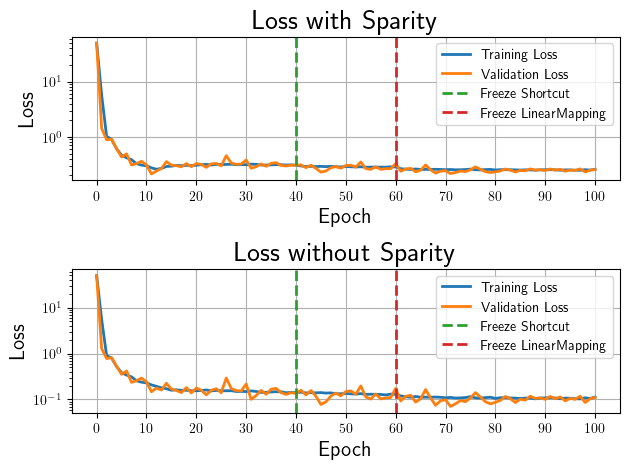

In [14]:
plt.rcParams["text.usetex"] = True
Loss_Epoch_Diagram = LOSS_EPOCH_DIAGRAM_TWO_LOSS(
    LOSS_HISTORY_TUPLE=(
        Loss_1_Training_History,
        Loss_1_Validation_History,
        Loss_2_Training_History,
        Loss_2_Validation_History,
    ),
    CONFIG=config,
    LAYER_NAME=["Shortcut", "LinearMapping"],
)

Final loss.

In [15]:
Loss_2_Training_History[-1], Loss_2_Validation_History[-1]

(0.11284037864198217, 0.11080362723408)

Shortcut visualization.

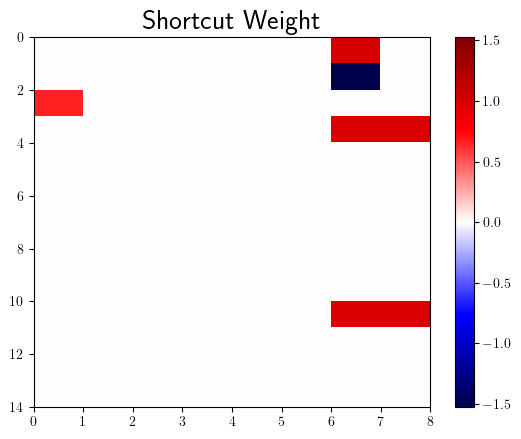

In [16]:
data_temp = Net.Shortcut.weight.detach().to("cpu").numpy()
Shortcut_Weight_Visualization = VISUALIZE_MATRIX(
    data_temp, config["VISUALIZATION"]["SHORTCUT_WEIGHT"], "Shortcut Weight"
)

Linear Mapping Matrix Visualization.

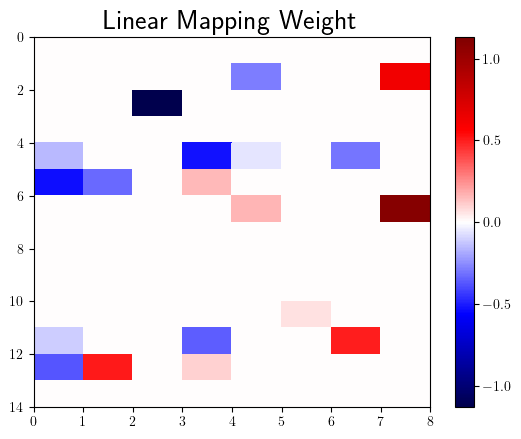

In [17]:
data_temp = Net.LinearMapping.weight.detach().to("cpu").numpy()
Linear_Mapping_Weight = VISUALIZE_MATRIX(
    data_temp, config["VISUALIZATION"]["LINEAR_MAPPING_WEIGHT"], "Linear Mapping Weight"
)

Hadmard Layer Visualization.

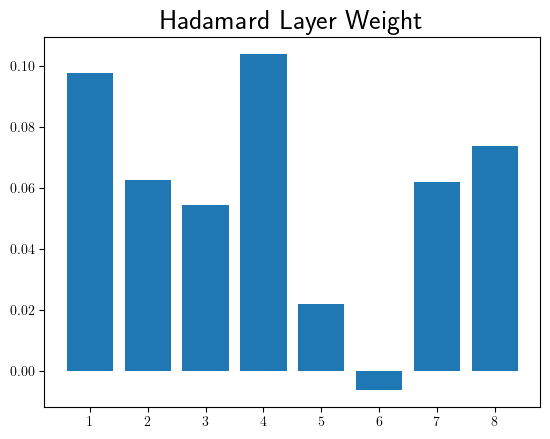

In [18]:
plt.bar(
    np.arange(1, config["NETWORK"]["EMBEDDING_SIZE"] + 1),
    Net.Hadamard.weight.detach().to("cpu").numpy(),
)
plt.title("Hadamard Layer Weight", fontsize=20)
plt.show()

Linear Layer Weight Visualization.

In [19]:
def VISUALIZE_ResBlockWeight(NN, CONFIG):
    NUM_LAYERS = len(NN)
    if CONFIG["NUM_ROW"] == -1 or CONFIG["NUM_COL"] == -1:
        NUM_ROW = int(np.floor(np.sqrt(NUM_LAYERS)))
        NUM_COL = int(np.ceil(np.sqrt(NUM_LAYERS)))
    else:
        NUM_ROW = CONFIG["NUM_ROW"]
        NUM_COL = CONFIG["NUM_COL"]
    INPUT_SHAPE = NN[0].Linear.weight.shape[1]
    FIG_SIZE = CONFIG["FIG_SIZE"]
    if FIG_SIZE[0] == -1 or FIG_SIZE[1] == -1:
        fig, ax = plt.subplots(NUM_ROW, NUM_COL, dpi=CONFIG["DPI"])
    else:
        fig, ax = plt.subplots(NUM_ROW, NUM_COL, figsize=FIG_SIZE, dpi=CONFIG["DPI"])
    if NUM_ROW == 1 or NUM_COL == 1:
        for i in range(NUM_LAYERS):
            data_temp = NN[i].Linear.weight.detach().to("cpu").numpy()
            VISUALIZE_MATRIX_AX(ax[i], data_temp, CONFIG, f"Layer {i+1}")
            if i == 0:
                ax[i].set_xticks(int(INPUT_SHAPE / 5) * np.arange(1, 6))
                ax[i].set_xticklabels(
                    [
                        r"$\sin(r_i)$",
                        r"$\cos(r_i)$",
                        r"$v_i$",
                        r"$\phi_{i}$",
                        r"$\psi_{i}$",
                    ]
                )
    else:
        for i in range(NUM_LAYERS):
            data_temp = NN[i].Linear.weight.detach().to("cpu").numpy()
            VISUALIZE_MATRIX_AX(
                ax[i // NUM_COL, i % NUM_COL], data_temp, CONFIG, f"Layer {i+1}"
            )
            if i == 0:
                ax[i // NUM_COL, i % NUM_COL].set_xticks(
                    int(INPUT_SHAPE / 5) * np.arange(1, 6)
                )
                ax[i // NUM_COL, i % NUM_COL].set_xticklabels(
                    [
                        r"$\sin r_i$",
                        r"$\cos r_i$",
                        r"$v_i$",
                        r"$\phi_{i}$",
                        r"$\psi_{i}$",
                    ]
                )
    plt.tight_layout()
    return fig

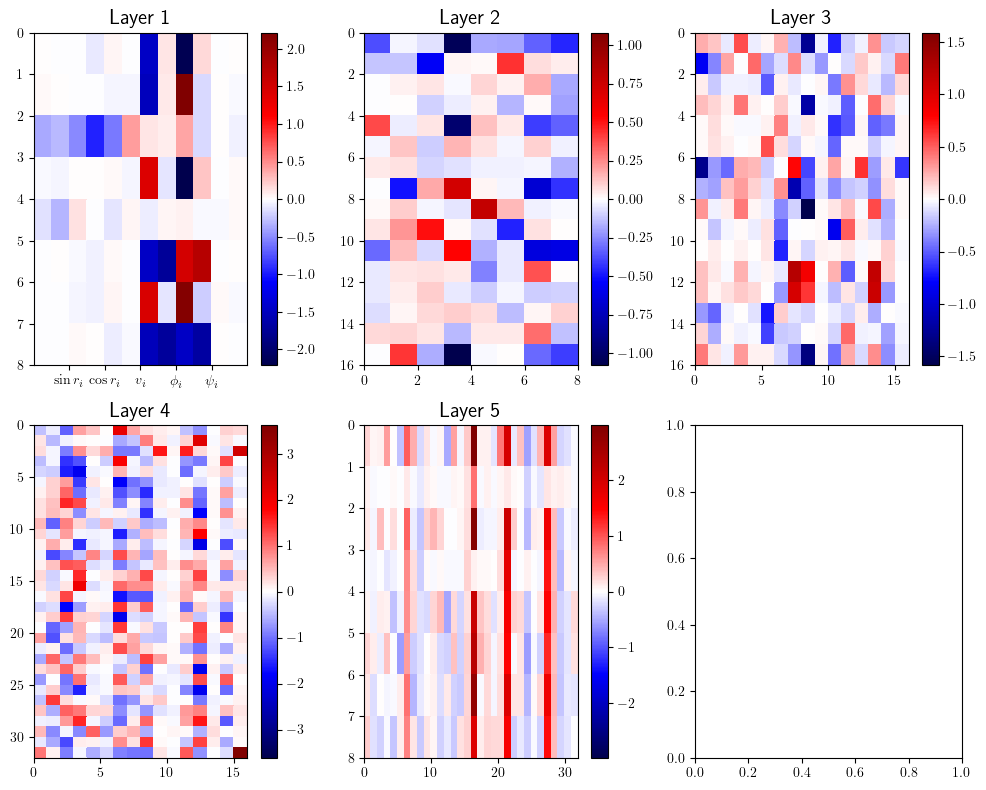

In [20]:
NN_Weight = VISUALIZE_ResBlockWeight(Net.NN, config["VISUALIZATION"]["NN_WEIGHT"])

## 4. Error on Test Data

Test Data

In [21]:
test_input_data = []
test_output_data = []
for data in TestLoader:
    test_input_data += data[0].detach().to(GET_DEVICE(config["TRAIN"]["DEVICE"]))
    test_output_data += data[1].detach().to("cpu")

test_output_fromData = torch.stack(test_output_data).numpy()

Obtain output computed from model.

In [22]:
Net.eval()
test_ouput_fromModel = (
    torch.stack([Net(test_input) for test_input in test_input_data])
    .to("cpu")
    .detach()
    .numpy()
)

Compute standard deviation and extreme error of each element.

In [23]:
import itertools

StandardDeviation = np.zeros((1, test_ouput_fromModel.shape[1]))
ExtremeError = test_ouput_fromModel[:2, :] - test_output_fromData[:2, :]
for i, j in itertools.product(
    range(test_ouput_fromModel.shape[0]), range(test_ouput_fromModel.shape[1])
):
    StandardDeviation[:, j] += np.power(
        test_ouput_fromModel[i, j] - test_output_fromData[i, j], 2
    )
    ExtremeError[0, j] = max(
        ExtremeError[0, j], (test_ouput_fromModel[i, j] - test_output_fromData[i, j])
    )
    ExtremeError[1, j] = min(
        ExtremeError[1, j], (test_ouput_fromModel[i, j] - test_output_fromData[i, j])
    )
StandardDeviation = np.sqrt(StandardDeviation) / test_ouput_fromModel.shape[0]
StandardDeviation = StandardDeviation.reshape(
    -1,
).tolist()
UpperError = ExtremeError[0, :].tolist()
LowerError = ExtremeError[1, :].tolist()

Visualization.

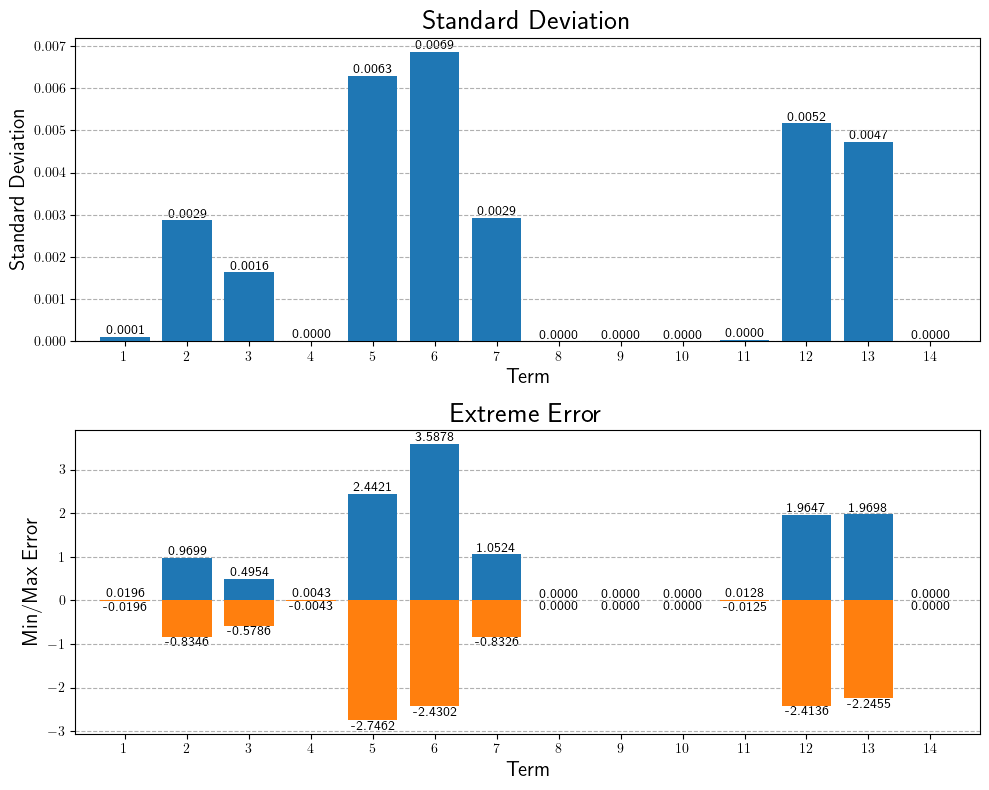

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Standard Deviation
axs[0].bar(np.arange(len(StandardDeviation)) + 1, StandardDeviation, zorder=5)
for i in range(len(StandardDeviation)):
    axs[0].text(
        i + 1,
        StandardDeviation[i],
        "{:.4f}".format(StandardDeviation[i]),
        ha="center",
        va="bottom",
        zorder=1,
    )
axs[0].set_xticks(np.arange(len(StandardDeviation)) + 1)
axs[0].set_xlim([1 - 0.8, len(StandardDeviation) + 0.8])
axs[0].set_title("Standard Deviation", fontsize=20)
axs[0].set_xlabel("Term", fontsize=15)
axs[0].set_ylabel("Standard Deviation", fontsize=15)
axs[0].grid(axis="y", linestyle="--", zorder=0)


# Upper Error
axs[1].bar(np.arange(len(UpperError)) + 1, UpperError, zorder=5)
# Lower Error
axs[1].bar(np.arange(len(LowerError)) + 1, LowerError, zorder=5)
for i in range(len(UpperError)):
    axs[1].text(
        i + 1,
        UpperError[i],
        "{:.4f}".format(UpperError[i]),
        ha="center",
        va="bottom",
        zorder=1,
    )
    axs[1].text(
        i + 1,
        LowerError[i],
        "{:.4f}".format(LowerError[i]),
        ha="center",
        va="top",
        zorder=1,
    )
axs[1].set_xticks(np.arange(len(UpperError)) + 1)
axs[1].set_xlim([1 - 0.8, len(UpperError) + 0.8])
axs[1].set_title("Extreme Error", fontsize=20)
axs[1].set_xlabel("Term", fontsize=15)
axs[1].set_ylabel("Min/Max Error", fontsize=15)
axs[1].grid(axis="y", linestyle="--", zorder=0)

plt.tight_layout()
plt.show()

Histogram of dominating error terms.

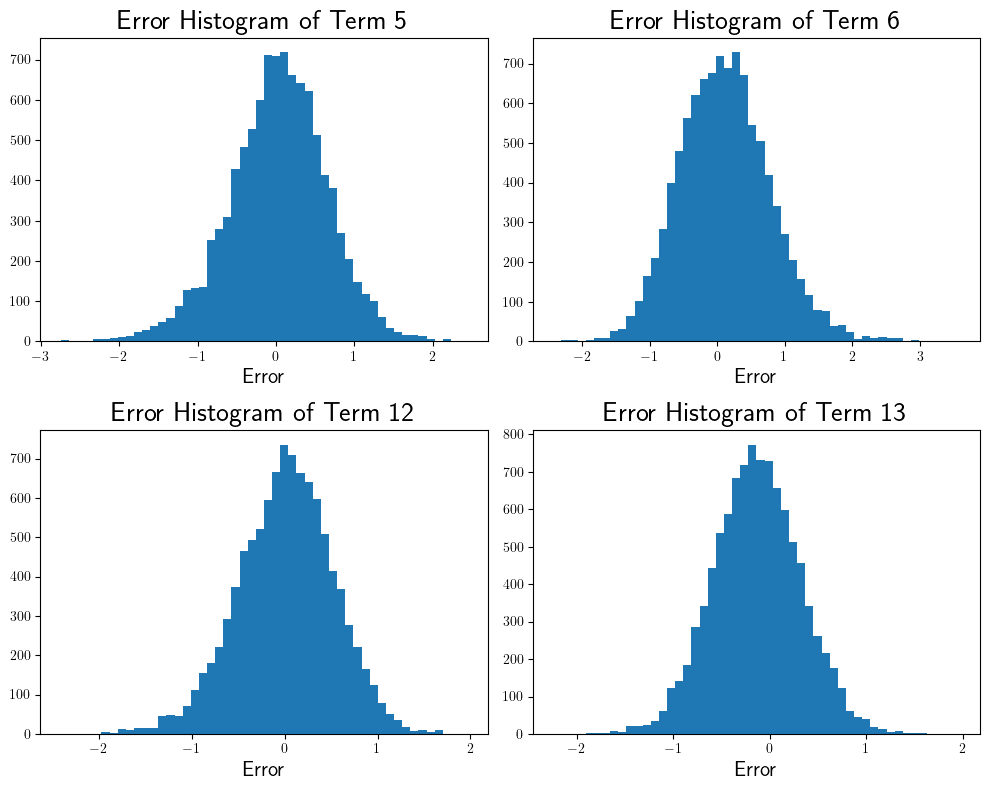

In [25]:
HistedTermIndex = [4, 5, 11, 12]
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i in range(4):
    axs[int(np.floor(i / 2)), np.mod(i, 2)].hist(
        test_ouput_fromModel[:, HistedTermIndex[i]]
        - test_output_fromData[:, HistedTermIndex[i]],
        bins=50,
    )
    axs[int(np.floor(i / 2)), np.mod(i, 2)].set_xlabel("Error", fontsize=15)
    axs[int(np.floor(i / 2)), np.mod(i, 2)].set_title(
        f"Error Histogram of Term {HistedTermIndex[i]+1}", fontsize=20
    )

plt.tight_layout()
plt.show()